In 2025 my relative showed me this project. 100% profit per month, thats a lot
I saw on the project web-site (epic-bytes.com), that the idea  - its use AI for trading.
Every day you must switch tumbler to get 2% profit.
Its not really, but people want to see the digital prufs.
OK, GO

 OK, as the first step i wanted to analyze their TRC-20 wallets. to start i choose their withdrawal adress -
- TUoiVJhUJVYPdzzFz3js8iV4JmTVGP8vHU
My ideas: look the receipts patterns; calculate IN-OUT $USDT amounts, look the adresses, which send money to our
withdrawal addresses.
file - byteEpic analysis.py

Firstly i wanna to parse incomming transes to the withdrawal adress
Secondly i wanna to parse incomming transes to this adress

In [7]:
import requests
import csv
import time
import os


API_URL = "https://api.trongrid.io/v1/accounts/{address}/transactions/trc20"
ADDRESS = "TUoiVJhUJVYPdzzFz3js8iV4JmTVGP8vHU"  # adress which you want to parse
LIMIT = 200
OUTPUT_FILE = "../byteEpic_strategy/byteepic_analysis_in.csv"  # change file name if you need 2 files: with input and with withdrawal transactions
TOKEN_ADDRESS = "TR7NHqjeKQxGTCi8q8ZY4pL8otSzgjLj6t"  # usdt trc-20 contract


def get_last_timestamp():
    if not os.path.exists(OUTPUT_FILE):
        return None

    with open(OUTPUT_FILE, "r", encoding="utf-8") as f:
        reader = csv.reader(f, delimiter=';')
        next(reader, None)
        rows = list(reader)
        if rows:
            return int(rows[0][4])  # take a timestamp new transaction
    return None

    
def save_to_csv(data):
    file_exists = os.path.exists(OUTPUT_FILE)

    with open(OUTPUT_FILE, "a", encoding="utf-8", newline="") as f:
        writer = csv.writer(f, delimiter=';')

        if not file_exists:
            writer.writerow(["transaction_id", "from", "to", "value", "timestamp", "fee"])  # Заголовки

        writer.writerows(data)

def fetch_transactions():
    max_timestamp = get_last_timestamp()
    transactions = set()

    while True:
        print(f"Запрашиваю данные с max_timestamp={max_timestamp}")

        params = {
            "limit": LIMIT,
            "only_to": True, #set True if you need two files (think HOW)
            "only_from": False, #set True if you need two files (think HOW)
            "only_confirmed": True,
        }
        if max_timestamp:
            params["max_timestamp"] = max_timestamp  # we are doing this because we dont want repeated entries

        response = requests.get(API_URL.format(address=ADDRESS), params=params)

        if response.status_code != 200:
            print(f"Ошибка HTTP: {response.status_code}")
            time.sleep(10)
            continue

        data = response.json()

        if not data.get("data"):
            print("Данные закончились. Жду 10 секунд перед повторным запуском.") # translate: data has run out. I wait 10 seconds before starting
            time.sleep(10)
            continue

        new_transactions = []

        for tx in data["data"]:
            if tx.get("token_info", {}).get("address") == TOKEN_ADDRESS:
                tx_id = tx["transaction_id"]
                if tx_id in transactions:
                    continue  # we are doing this because we dont want repeated entries

                transactions.add(tx_id)
                value = int(tx.get("value", 0)) / (10 ** int(tx["token_info"].get("decimals", 6)))
                new_transactions.append([
                    tx_id,
                    tx["from"],
                    tx["to"],
                    value,
                    tx["block_timestamp"],
                    tx.get("fee", "N/A")
                ])

        if new_transactions:
            max_timestamp = new_transactions[-1][4] - 1  # uodate max_timestamp
            save_to_csv(new_transactions)
            print(f"Добавлено {len(new_transactions)} новых транзакций.") #translate: added {len} new transactions

        time.sleep(0.2)  # i have a free api-token, ha has a limits


if __name__ == "__main__":
    fetch_transactions()

Запрашиваю данные с max_timestamp=None
Добавлено 200 новых транзакций.
Запрашиваю данные с max_timestamp=1740383426999
Добавлено 200 новых транзакций.
Запрашиваю данные с max_timestamp=1736585219999
Добавлено 200 новых транзакций.
Запрашиваю данные с max_timestamp=1730989517999
Добавлено 182 новых транзакций.
Запрашиваю данные с max_timestamp=1726317728999
Данные закончились. Жду 10 секунд перед повторным запуском.
Запрашиваю данные с max_timestamp=1726317728999
Данные закончились. Жду 10 секунд перед повторным запуском.


KeyboardInterrupt: 

What we can see after this?
I save input transactions to one file, withdrawals i saved to the second file
How it lookss?
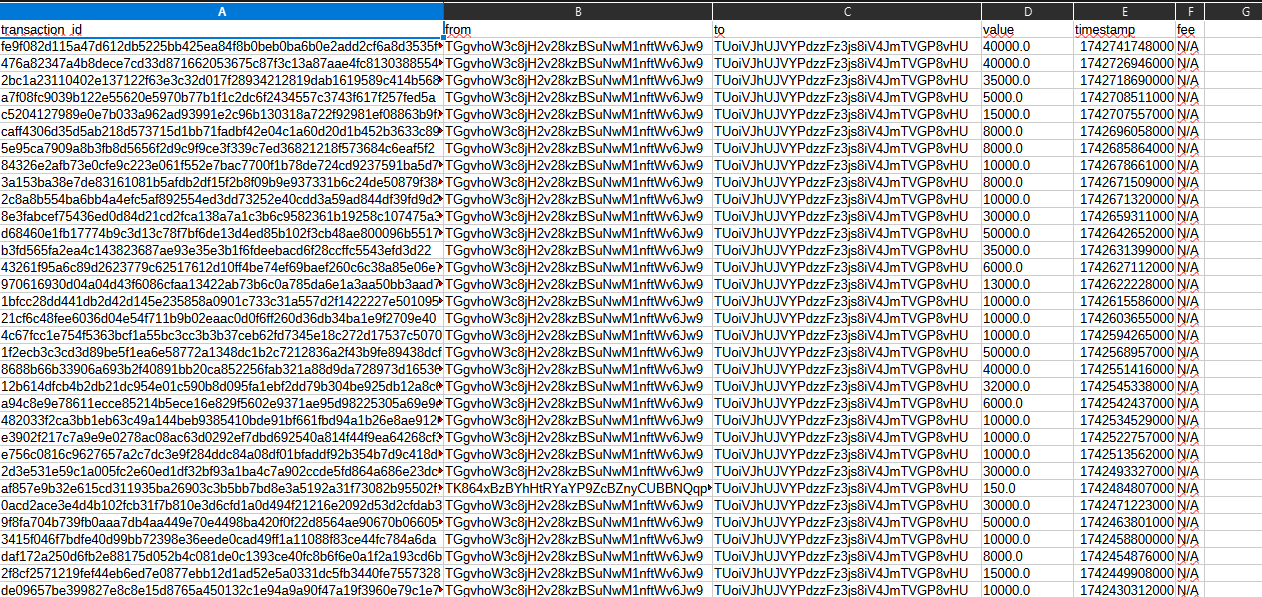
I have summarized the relevant transactions:

In [9]:
with open('byteepic_analysis_out.csv', mode='r', encoding='UTF-8') as f: #change file name
    reader = csv.reader(f, delimiter=';')
    rows = list(reader)
    adress = "TUoiVJhUJVYPdzzFz3js8iV4JmTVGP8vHU"
    sum_in = 0
    sum_out = 0
    for i in rows[1:]:
        if len(row) > 3: 
            value = float(row[3].strip())
            if row[2].strip() == address:
                sum_in += value
            if row[1].strip() == address:
                sum_out += value
print(sum_in)
print(sum_out)

100.0
6705090.560000009


In [ ]:
Hmmm, so small
6_803_172 IN
6_705_090 OUT
IN - OUT = about 118_000 $

Maybe, i can check adresses, whic send money to our withdrawal adress?

Ok, go

Thirdly, i want to create a group of adresses, which send money to out withdrawal adress
For this i will use next python script

In [18]:
with open('byteepic_analysis_in.csv', mode='r', encoding='UTF-8') as f:
    reader = csv.reader(f, delimiter=';')
    rows = list(reader)
    adresses = []
    for row in rows[1:]:
        adress = row[1]
        if adress not in adresses:
            adresses.append(adress)
print(adresses)

['TGgvhoW3c8jH2v28kzBSuNwM1nftWv6Jw9', 'TK864xBzBYhHtRYaYP9ZcBZnyCUBBNQqp9', 'TELGvxXTvvccL29fMo25qTKvLfCqPfsZTE', 'TTefbWfN1qpmYTeF9TPefNgQ5TMLUCuTrC', 'TUoiVJhUJVYPdzzFz3js8iV4JmTVGP8vHU']


result:
'TGgvhoW3c8jH2v28kzBSuNwM1nftWv6Jw9', [1]
'TK864xBzBYhHtRYaYP9ZcBZnyCUBBNQqp9', [2]
'TELGvxXTvvccL29fMo25qTKvLfCqPfsZTE', [3]
'TTefbWfN1qpmYTeF9TPefNgQ5TMLUCuTrC', [4]
'TUoiVJhUJVYPdzzFz3js8iV4JmTVGP8vHU' #i think that its real because the wallet owner used the bridge

Third, we can summarize the incoming and outgoing transactions for each adress, using the our code
In  CSV file we can see the transactions, which parse with the biggest sum (more than 1e20....) 
They are linked to sunswap. We will deal with them later, but for now we will just ignore such an amount

In [21]:
with open('byteepic_analysis_3.csv', mode='r', encoding='UTF-8') as f:
    reader = csv.reader(f, delimiter=';')
    rows = list(reader)
    sum_in = 0
    sum_out = 0
    address = "TELGvxXTvvccL29fMo25qTKvLfCqPfsZTE"

    for row in rows[1:]:
        if len(row) > 3: 
            value = float(row[3].strip())
            if value < 1e12:
                if row[2].strip() == address:
                    sum_in += value
                if row[1].strip() == address:
                    sum_out += value
print(sum_in)
print(sum_out)

5130833.039444984
5130833.039444999


Adress_1 result:
3930402
3907954;
Adress_2 result:
209
209;
Adress_3 result:
5130833
5130833;
Adress_4 result:
5330742
5330742;

Hmmmm... We can see that these wallets play the role of “gaskets”. We have to keep checking! Let's check the admission addresses. 
And address 2 is out of the race for now, since there's only one transaction there.

In [26]:
with open('byteepic_analysis_4.csv', mode='r', encoding='UTF-8') as f:
    reader = csv.reader(f, delimiter=';')
    rows = list(reader)
    adresses = []
    for row in rows[1:]:
        adress = row[1]
        if adress not in adresses:
            adresses.append(adress)
print(adresses)

['TTefbWfN1qpmYTeF9TPefNgQ5TMLUCuTrC', 'TLPzBEC7hTZyBbo384GBzvZTD39zf2A78o', 'TELGvxXTvvccL29fMo25qTKvLfCqPfsZTE', 'TVZUenc7aJD11rKJeGCLExfDr7VUR64wsW', 'TVXZntjksjnr8aFpYX5EKervJE7hockFZW', 'TBL56Se4ajVJNf7hbNTcmp57h6zsRhwQC2', 'TLgr9XxjpER9htNzZEFGQUrd2cGSWhwQC2', 'TRuqiMmkgqzkS5X3ATspz4uLEgvq5hRwuq', 'TJSuMtLZAsJDdA6vWXHvnkPKiwhKmbcCyF', 'TCNhphj33B6EY1HAAvnRoPYkeDgTD5b4gG', 'TTvwFPCJjw9c6Uh74rjj16mdTYBBQTG7At', 'TYa6Zi2j1pCFUCvr1Veh7jrAe8xybYNmTd', 'TRrEFmDjqrmdc2bTELDPKC2SB2Cp4qo6Zp', 'TUcouFXe7gZctDkh9pCFYGDn1A442SMyJX', 'TZAaUtohvz6ZAvpznGvpnAZjADEEvJ2ahr', 'TRjTSDrKfGtNynNjjnDo8tYpt6WFPVkfHd', 'TJMyJUVDZBCcKme9a7Vcf3GSM7VNa3xnXD', 'TLN3QBxnb7zfRDz7sUc5SmHMkY9AArtxZG', 'THYPrH7hzJftvDuRs3RcxvM2Zt48k5w7s4', 'TLdrdgvU9o2a4hJoUUkQd8wiTDc8FwTyKz', 'TPjjWetVufLo649WYaZRdufHTWtDkZpVhu', 'TQTBPHXhNYHfkc6VJbp61cCyGPJycAUoCA', 'TEcSG5mKvf6GXFt2uybDG8V69vjpg38G5d', 'TKLmHD2TGm9AN9pAPCNa7oJBtgEuG24HpV', 'TYWhg6u4QtX4yrnjLjoT9DrqWzfWXE8PtN', 'TSeXcCfVxBimoaezRasMjZ4Aqe2ZVLrFkH', 'TLDehaEnxd

adress_1 : ['TGgvhoW3c8jH2v28kzBSuNwM1nftWv6Jw9', 'TEbevrcfd7RumHR7JAQr5uo2qJDaqVyWbv', 'TLPzBEC7hTZyBbo384GBzvZTD39zf2A78o', 'TXqbJtXpswU4UCRpzCFLd8G6nXyoAEubYr', 'TN2dSJNLnvM4DeHFBZBiNHv9ELNEYUh9BX', 'TTTHovXAbGFjW8ivyqGNxZpmtdZ3eWCs4z', 'TA8ycLTKqV9h1JWcWG2TUevy9eRxCVomoD', 'TXEAbnuoBHM8DN49MY9aaFHLRXg3X46dsD', 'TYhPdvXTXCbRThJcJ9Nb1tdNq1iBzsDEMe', 'TNWrFgv24gquoRb1ndcXzMW8mJFRMyqmr8', 'TGdZ4gdJEpPBczLyscr92ebzJ5iyunZCKb', 'TCLwpHKYMRBEYYUngVR2sKGBDwkctu8MLm', 'TNpA8E2KqY29gc4PKJGd6hS1VEn5tu8MLm', 'TCLwL8Wujh9xMPZUj6cGX6F7ner3ou8MLm', 'TN2sU2zacZ4ciHFobgNfBMrRkZGoYUh9BX', 'TBbpJWBHdCihob58QCeqKKbGEgrVxUCQhv', 'TYwUPHM9UfX3AUUoyZSusqDTgVWnSfE2vo', 'TVDCJ3qFhzUoDRhSPbm3NWwYLionvx2Q7A']

adress_3 : ['TELGvxXTvvccL29fMo25qTKvLfCqPfsZTE', 'TTaXyjTunnPPfFGhNLpnR4ft7y5A9XNgyB', 'TLPzBEC7hTZyBbo384GBzvZTD39zf2A78o', 'TDNKnLeM6TdvUmus3mnSLYQe9NJ8yDa6Cm', 'TKHaj6RtjuZ6YX5jSbd6A4wjZUTQkc7hLg', 'TVZUenc7aJD11rKJeGCLExfDr7VUR64wsW', 'TAcQwjjrwfDLAjfdfu6rodudpf1QjGyBFJ', 'THEc7YxSLExRNtbXi6ezg2pnrMxj2JEsVN', 'TCzzQqkAQReNd9xrQ4aEbYd3eVSXVDxsfC', 'TTefbWfN1qpmYTeF9TPefNgQ5TMLUCuTrC', 'TX1kdirGeMoUTQ2UTVZD7LoEzHeL1GivCV', 'TUoiswXyrUbo6zhWEx3qGoiK7qvFcP8vHU', 'TUThTRZQhT25hENYiyRPUsmX9HrdZP8vHU', 'TPjjWetVufLo649WYaZRdufHTWtDkZpVhu', 'TXjueP9wqrGgQTZidWBkQpAjd79LXxAvZ6', 'TKRRQvDC27PnY6bATVHLW4LTTVsc4uJdTy', 'TQYgjAgHgzUe8Po5BMa4ZkRrh6gDDtsxqW', 'TNi9r7ibjg6hZu8ttkTT7zEQBGGLfKhWLp', 'TA3MfmkGrDdAENaEXUFhFFxhmXyUjK7wUT', 'TKfBnyKgaxfMCrJpHsVRjhYUStpPoM1eFV', 'TXyKZmgZGPAqQKRMR57LsV37DS4L8uHNPa', 'TWRQWTKwwSzp5Mf4bBtVs368wAoNjNDX2m', 'TUbYqBpg8r9FRD99TjPBWvLeZrRSAP8vHU', 'TVXZntjksjnr8aFpYX5EKervJE7hockFZW', 'TRBLNeLaRYanxbuDaZq8aDwPecYs3tgDWT', 'TNasaWus6VfkucfhUjMiNWEGHLyVimWbP5', 'TSiRuWGmL5ENHz1f9AWiGaY1t424sCSRgS', 'TKSMGrKx4Zm8gHW3mAqjVH3MZau7fzmWBx', 'TJmiPMHXNL74yUyDv51XCb7LUnuqjGyBFJ', 'TLhW8WgqMyi83wWZJCS2CwHrB1sMWBU1hX', 'TKKSBHgFvKPXoM9wBULT3kVqUxZoYa2k8c', 'TYXRXRk7YiXL7n8kUSzLouZg633GJqtGme', 'TWviwYjeMgqeDBExKo2Fe6gzkz68xBt1jy', 'TSKVbortN7owdjwf3tXKk6oGGe5LAL3U6s', 'TAgc1hN7TeEE4eG9jYh5R1mwj9znxLPgVC', 'TE7p3WrHr4aT4L1sXQyuxWjGaQFAFzBzgs', 'TTd6wAzCC8yDA1g2u7gSyhQF5iAdmsA8fP', 'TRsEyfaQwdYYgAfQ9mSXXTsXmkqhEmpwYr', 'TU64F2vPQCYwGKcsmNSDusgvjzGkKP8vHU', 'TKTXhXzjih2s1P4XwJjLopMzomtib98SzN', 'TJud8LPGjipnavPLYLeX8MxBpKfHAgZfHR', 'TF1E9HFJ1MsRXmhMS2KvdqTiDq9658KxJo', 'TUokcZJtk5NruSV6dpKiBkYE8CP1GP8vHU', 'TC31LsB3tSyPtmwS1LZyTMhoLypqbnxZ9U', 'THYczSVqccouAFeqXUtWEczFBABHsSQk9Q', 'TH357WyCoZDRKSca3Yp9dwupi66NyYDDks', 'TTv4jGzzwAuBzX8rHpHnNoXBWGjqy48RL8', 'TP3A3WbLkqtVfVtyJ5qgsK2mkw6qtGBebb', 'TApK1TXrC8yaqdg8RbuPJUpFg1dm38K1jw', 'TD4Q89jaZFcH2miRhLMjq9pevBPoAUuy1z', 'TSvxciNCCDesfnN3gX9TN4nTkNMiq31ek3', 'TTXnHGKJL6XroTW1UMQpeYN9xUJ24YHnyw', 'TEiY33Fw12XT2XoFttk3y2q4unbwGADJ86', 'TTtAKT8HcPeiKeye3caLDEhN7k1CRR1RSZ', 'TCMQE8yrCEzCFNw7RvWhV91xWqUK9zrmDN', 'TCMw1erkfmDPGpdpeiRq42Yw1yFPophLoQ', 'TNivwoGYsctXhyaU4UpqLxfdzkRs6CxJAK', 'TGHzMauTRzG9sp3p2VV4oF6c76gtirfQCo', 'TRGYiD2ASXamKyYMJVKVrMVJSvSunrfQCo', 'TVMqWeDw9pTqsbaNEKGmR8dtastVGU655K', 'TKrTct5ZqpBRe9CfcAWuNxeEqp1Fyr3Ank', 'TChvfCfTfJmKZCuw9mNjgEayvJMcWr3Ank', 'TMYNbKxYmqFnEX25qgVRg3D1a8mAPkPT3o', 'TE77rdj8vprFUjKnyixGX4kwxprkCkPT3o', 'TMPTUXp5QLaEyLPUbYcfhnk6bu1HDkPT3o', 'TMCXsevHGieqrkw15saYUFTqgDeYhkPT3o', 'TM1eA91psk1CfxMuPjfYz6CKwxH7GkPT3o', 'TMaiNaDH4RGcQGMPJkqNhv4XkXTKQkPT3o', 'TQ6cgqpLS3niUXCPAUdaBE4JSAxQqCg3gN', 'TQe4af6RayEbi9gDnzKMWKrQdNm1vw4kVB', 'TMVvnF3aqySjpmDHYqZVRG62R5b6vw4kVB', 'TMCaEujQpNrm7R3eo14ZKpGUKcjn6fXK6o', 'TANhe3RHygUqEBPXxc3Hq1YaPo54LfXK6o', 'TGVqj6gdruXSXikDm8aFkKTg3u6YcpWGDh', 'TU8LRg8zpnFRNc4f6dBLJFBTAf7UCP8vHU', 'TU7QvaTNYKUVQmYYket28yTL2XMmGP8vHU', 'TWbnhtqG5CJXcqP7koCaNhWL8zYWsWdJcG', 'TBo8tsigSVs3ioeN4m2pHyeu5uUGWHkDFG', 'TCN1TxVcnY2t3VLk2xwV3xqJnPgcjw4CY5', 'TKDppCLEVgRc5LHYbYtwH7uH25AhNPSekq', 'TURb8cnP3vPkNPACQdbB9ci6dpzkAP8vHU']

adress_4: ['TTefbWfN1qpmYTeF9TPefNgQ5TMLUCuTrC', 'TLPzBEC7hTZyBbo384GBzvZTD39zf2A78o', 'TELGvxXTvvccL29fMo25qTKvLfCqPfsZTE', 'TVZUenc7aJD11rKJeGCLExfDr7VUR64wsW', 'TVXZntjksjnr8aFpYX5EKervJE7hockFZW', 'TBL56Se4ajVJNf7hbNTcmp57h6zsRhwQC2', 'TLgr9XxjpER9htNzZEFGQUrd2cGSWhwQC2', 'TRuqiMmkgqzkS5X3ATspz4uLEgvq5hRwuq', 'TJSuMtLZAsJDdA6vWXHvnkPKiwhKmbcCyF', 'TCNhphj33B6EY1HAAvnRoPYkeDgTD5b4gG', 'TTvwFPCJjw9c6Uh74rjj16mdTYBBQTG7At', 'TYa6Zi2j1pCFUCvr1Veh7jrAe8xybYNmTd', 'TRrEFmDjqrmdc2bTELDPKC2SB2Cp4qo6Zp', 'TUcouFXe7gZctDkh9pCFYGDn1A442SMyJX', 'TZAaUtohvz6ZAvpznGvpnAZjADEEvJ2ahr', 'TRjTSDrKfGtNynNjjnDo8tYpt6WFPVkfHd', 'TJMyJUVDZBCcKme9a7Vcf3GSM7VNa3xnXD', 'TLN3QBxnb7zfRDz7sUc5SmHMkY9AArtxZG', 'THYPrH7hzJftvDuRs3RcxvM2Zt48k5w7s4', 'TLdrdgvU9o2a4hJoUUkQd8wiTDc8FwTyKz', 'TPjjWetVufLo649WYaZRdufHTWtDkZpVhu', 'TQTBPHXhNYHfkc6VJbp61cCyGPJycAUoCA', 'TEcSG5mKvf6GXFt2uybDG8V69vjpg38G5d', 'TKLmHD2TGm9AN9pAPCNa7oJBtgEuG24HpV', 'TYWhg6u4QtX4yrnjLjoT9DrqWzfWXE8PtN', 'TSeXcCfVxBimoaezRasMjZ4Aqe2ZVLrFkH', 'TLDehaEnxd4rJTfGh2LG7v3iv2NHshvhxK', 'TDNNsND3tRVPHaHYjPKVzu6reqdVrYEtKN', 'TJDhZU4oUyQeJg1K89ywEHKPseBg7Kwche', 'TXKhFv99wDMCg2k8istuhPRRyTHRBatnKM', 'TKswHeFso375g2wqtKP7NveHqzEZk3mYe3', 'TEFufpPcDh2i8Uw6vfWL4w4KZJqqK1GUKV', 'TYnMEAPdNjkQQiwi526eUFrAB7VpjSMkeP', 'TM7fv2emqqZMaeJxkBzG67DcQ5qQeHGhEb', 'TYvbJSDBQ8grdk1vD1frMHd6a4ywVTze8Y', 'TAFPdFq1g9JsWQWgJfkx48FZWzNsRA2YTa', 'TLpGSgQPqvajAcnirpgp9gjpTQRgfL5qPK', 'TN3KjinrFULQYUASssdwmmfUGACwmaF9M3', 'TYeGNCeKTnzienGU23ZM9mSX11RWaYtiqq', 'TBeYZM8s3wvhz9C7NUM3XJ2kL58A5po67X', 'TEcMpsBu7rp6H52uJVeMsh5a7onCP9GSSQ', 'TH2hSdKiCbNsKNsyiVuWzoHiUu4WqYG6gZ', 'TFuqA2SQyLm8Tc9y8BNY1jhkxGybndGjgY', 'TLH8cF8jRftLGmoK4QUkCvFv17i59zw3aP', 'TWG3Wnturc875oFZ3gDHggeuBxG6Qrszvg', 'TDfQ5Z5S4v1VHPJ4zZxJEncBhUPhFZdEG8', 'THQgw5N4MKUEC8ckJWbuVFTKMYdSbz5ovX', 'TNSDDb6Wy5DHxCHEMWyfJ54E5Udh57Ct9H', 'TBkErzDypaXVoqFb3v1m7Zw6Ru51CaiAw3', 'TQdW3YpSoJdhpcX2WLu73we4Fq5GGGciDb', 'TBVQzfDCnMyVwndwhhJyodfxoGvg81VAFv', 'TQr6enqBSHLr4oDWG76W2LrvkdVUvHkYqB', 'TSU2b2fEbgb9sYSWLWThhavJkmWiEjKMQx', 'TH9SZFAmqFm6CUNhqSaSfgsGDcmqdE5MQG', 'TLmoBgCUtH6PUn1Z74CpxTdpg5ijsV6mGF', 'TSrVyGjbyct98h5u6ruQh1tdsiy7rscuNw', 'TCzbiwfXLhfvAVLNAh1xz9RbyJ254Ueycs', 'TM1b12gRiefNk26oPZKURF4FW7ZGuGF6be', 'TJud8LPGjipnavPLYLeX8MxBpKfHAgZfHR', 'TRRcqW7AE1R6YHtvSP3v9o2pSop4ZpaP2J', 'TRZXdER8Z4Q7mQ7sHBjHCv5iCaeWAiEDU5', 'TPan4dLzVVX8N24fazNxiNqfamaxzMVu1N', 'TUMYCicE388uw1NoNvn3GpwNGFGSMcAFfc', 'TGuw4HG9Tjo1fjsyQYLoHb9fteB4Fs2BVH', 'TAM15om3cbEpWzv9HbckURoJgWssxigwGf', 'TNfFKgmxYAi2ogRTvkbYj3nJwPxEq6rtmW', 'TLAnH6ZrMWDjyQhMDf4z9oyCTkXuV3ugA2', 'TF1cDTkUXJcpKooVDgPuixVcBt73r2PTaN', 'TLTwUh7B9J7ezC26TJcKGoEozH2irr4xhU', 'TBzm4sEpWireZbnQDbAf7TfaUdweyhJbB9', 'TUKb6ufLyztWMyBZFrn2ovvdj2KUrM9wRw', 'TBaMqUwpSpLHLgWSnV8ra2eEViP6FwTyKz', 'TCfmE9kXawpfV61jFRQsNCjppq7LBiQAex', 'TDCZ3FmQsJ4XLsUn375XMqVEjxSrzfviaZ', 'THedMUqinosEgrTHSGy9XgjwPr5AT4Gfyj', 'TYV7dWkVi8ppGYuM18Y4MU9XhxQKfF659U', 'TFxPH1ZCY7ML16VRgqUv6uNMKshHuvvk35', 'TNF7cqWc5wXfS1WHU5YGxug8SjH9MtutWM', 'TJ4wyLmaqvBnvDqUKbnAV15fNtqWbo47xp', 'TH357WyCoZDRKSca3Yp9dwupi66NyYDDks', 'TF1E9HFJ1MsRXmhMS2KvdqTiDq9658KxJo', 'TQHDirYxCELQUU97qohxFeAsfhbLCsGYWK', 'TN16RZE5diXuLi82Ybcvh4un4Xjap7cR2w', 'TP3A3WbLkqtVfVtyJ5qgsK2mkw6qtGBebb', 'TGkHfYXkgUgHjAKcYf3gob2rLd1N7BqRQs', 'TFtzWYuyfwJZoPNJng1HkVpkUYAwrhwQC2', 'TQ85cfh6DL72P1DjJUdgwidPTCEdXy826C', 'TR2g4GqDd2BKPyjX4D69U42B385CHy826C', 'TAsMGH5xoHn1CiJ5Zz7JNUW4A4kCUW3fnw', 'TJocthvmoo2mreNhL6oKadZcaKUCettX1p', 'TGRVzhZfLb2JcWEvbftgDm241AUgJSVuLu', 'TA6LYoxVwHaANeYRK8FsLHj6sCtJsWpuYj', 'TG6ChYUDxUb39ucky8zMKSEZSRkGm6gWiR', 'TApK1TXrC8yaqdg8RbuPJUpFg1dm38K1jw', 'TTd6wAzCC8yDA1g2u7gSyhQF5iAdmsA8fP', 'TTd65omMayBadaZ4ouLuQeumKkh1rsA8fP', 'TTXnHGKJL6XroTW1UMQpeYN9xUJ24YHnyw', 'TSvxciNCCDesfnN3gX9TN4nTkNMiq31ek3', 'TVa6MsyRAMZdjC2YZa3DzYLnSXJbudsjKi', 'TEiY33Fw12XT2XoFttk3y2q4unbwGADJ86', 'TRMmmGJD6iZL4QFHYvHhUKzxyEVoRR1KuH', 'TBLSFmY2bgmZFx1MoTLeYa66bHuTJhwQC2', 'TBLyLkrerzRAynoUDMbPXkDssW2o1hwQC2', 'TBQrGPjMoAiJV3HqErTdYrFguF6ZmhwQC2', 'TVMqWeDw9pTqsbaNEKGmR8dtastVGU655K', 'TTkiNcDeW4mDGU5pD8YSfz8wDuoQSrwqsw', 'TBJmEMeJquThe5Ld4DcxaupVbYUuwhwQC2', 'TBL5yNYNXfeJEMpMvEQbnmxsYqu6HhwQC2', 'THkJLWrAnjoi4cSyXaCW2358wHAGYhiCP1', 'TJVXwPMyqYDF7VLDUEeojKfNDhamN8h24G', 'TW8d5d4fA3WDSQsCviFnwvmhPLZjBGLyFF']


know the principle of branching of its assets, then we can see that byteepic does not work like that. there is a system of “confusing traces” and mixing of assets. 

Ohhwwww...Its looks like so hard. Go to analysis! Maybe, we can try to check with shared wallet between these adresses?

In [32]:
adresses_1 = set(['TGgvhoW3c8jH2v28kzBSuNwM1nftWv6Jw9', 'TEbevrcfd7RumHR7JAQr5uo2qJDaqVyWbv', 'TLPzBEC7hTZyBbo384GBzvZTD39zf2A78o', 'TXqbJtXpswU4UCRpzCFLd8G6nXyoAEubYr', 'TN2dSJNLnvM4DeHFBZBiNHv9ELNEYUh9BX', 'TTTHovXAbGFjW8ivyqGNxZpmtdZ3eWCs4z', 'TA8ycLTKqV9h1JWcWG2TUevy9eRxCVomoD', 'TXEAbnuoBHM8DN49MY9aaFHLRXg3X46dsD', 'TYhPdvXTXCbRThJcJ9Nb1tdNq1iBzsDEMe', 'TNWrFgv24gquoRb1ndcXzMW8mJFRMyqmr8', 'TGdZ4gdJEpPBczLyscr92ebzJ5iyunZCKb', 'TCLwpHKYMRBEYYUngVR2sKGBDwkctu8MLm', 'TNpA8E2KqY29gc4PKJGd6hS1VEn5tu8MLm', 'TCLwL8Wujh9xMPZUj6cGX6F7ner3ou8MLm', 'TN2sU2zacZ4ciHFobgNfBMrRkZGoYUh9BX', 'TBbpJWBHdCihob58QCeqKKbGEgrVxUCQhv', 'TYwUPHM9UfX3AUUoyZSusqDTgVWnSfE2vo', 'TVDCJ3qFhzUoDRhSPbm3NWwYLionvx2Q7A'])
adresses_3 = set(['TELGvxXTvvccL29fMo25qTKvLfCqPfsZTE', 'TTaXyjTunnPPfFGhNLpnR4ft7y5A9XNgyB', 'TLPzBEC7hTZyBbo384GBzvZTD39zf2A78o', 'TDNKnLeM6TdvUmus3mnSLYQe9NJ8yDa6Cm', 'TKHaj6RtjuZ6YX5jSbd6A4wjZUTQkc7hLg', 'TVZUenc7aJD11rKJeGCLExfDr7VUR64wsW', 'TAcQwjjrwfDLAjfdfu6rodudpf1QjGyBFJ', 'THEc7YxSLExRNtbXi6ezg2pnrMxj2JEsVN', 'TCzzQqkAQReNd9xrQ4aEbYd3eVSXVDxsfC', 'TTefbWfN1qpmYTeF9TPefNgQ5TMLUCuTrC', 'TX1kdirGeMoUTQ2UTVZD7LoEzHeL1GivCV', 'TUoiswXyrUbo6zhWEx3qGoiK7qvFcP8vHU', 'TUThTRZQhT25hENYiyRPUsmX9HrdZP8vHU', 'TPjjWetVufLo649WYaZRdufHTWtDkZpVhu', 'TXjueP9wqrGgQTZidWBkQpAjd79LXxAvZ6', 'TKRRQvDC27PnY6bATVHLW4LTTVsc4uJdTy', 'TQYgjAgHgzUe8Po5BMa4ZkRrh6gDDtsxqW', 'TNi9r7ibjg6hZu8ttkTT7zEQBGGLfKhWLp', 'TA3MfmkGrDdAENaEXUFhFFxhmXyUjK7wUT', 'TKfBnyKgaxfMCrJpHsVRjhYUStpPoM1eFV', 'TXyKZmgZGPAqQKRMR57LsV37DS4L8uHNPa', 'TWRQWTKwwSzp5Mf4bBtVs368wAoNjNDX2m', 'TUbYqBpg8r9FRD99TjPBWvLeZrRSAP8vHU', 'TVXZntjksjnr8aFpYX5EKervJE7hockFZW', 'TRBLNeLaRYanxbuDaZq8aDwPecYs3tgDWT', 'TNasaWus6VfkucfhUjMiNWEGHLyVimWbP5', 'TSiRuWGmL5ENHz1f9AWiGaY1t424sCSRgS', 'TKSMGrKx4Zm8gHW3mAqjVH3MZau7fzmWBx', 'TJmiPMHXNL74yUyDv51XCb7LUnuqjGyBFJ', 'TLhW8WgqMyi83wWZJCS2CwHrB1sMWBU1hX', 'TKKSBHgFvKPXoM9wBULT3kVqUxZoYa2k8c', 'TYXRXRk7YiXL7n8kUSzLouZg633GJqtGme', 'TWviwYjeMgqeDBExKo2Fe6gzkz68xBt1jy', 'TSKVbortN7owdjwf3tXKk6oGGe5LAL3U6s', 'TAgc1hN7TeEE4eG9jYh5R1mwj9znxLPgVC', 'TE7p3WrHr4aT4L1sXQyuxWjGaQFAFzBzgs', 'TTd6wAzCC8yDA1g2u7gSyhQF5iAdmsA8fP', 'TRsEyfaQwdYYgAfQ9mSXXTsXmkqhEmpwYr', 'TU64F2vPQCYwGKcsmNSDusgvjzGkKP8vHU', 'TKTXhXzjih2s1P4XwJjLopMzomtib98SzN', 'TJud8LPGjipnavPLYLeX8MxBpKfHAgZfHR', 'TF1E9HFJ1MsRXmhMS2KvdqTiDq9658KxJo', 'TUokcZJtk5NruSV6dpKiBkYE8CP1GP8vHU', 'TC31LsB3tSyPtmwS1LZyTMhoLypqbnxZ9U', 'THYczSVqccouAFeqXUtWEczFBABHsSQk9Q', 'TH357WyCoZDRKSca3Yp9dwupi66NyYDDks', 'TTv4jGzzwAuBzX8rHpHnNoXBWGjqy48RL8', 'TP3A3WbLkqtVfVtyJ5qgsK2mkw6qtGBebb', 'TApK1TXrC8yaqdg8RbuPJUpFg1dm38K1jw', 'TD4Q89jaZFcH2miRhLMjq9pevBPoAUuy1z', 'TSvxciNCCDesfnN3gX9TN4nTkNMiq31ek3', 'TTXnHGKJL6XroTW1UMQpeYN9xUJ24YHnyw', 'TEiY33Fw12XT2XoFttk3y2q4unbwGADJ86', 'TTtAKT8HcPeiKeye3caLDEhN7k1CRR1RSZ', 'TCMQE8yrCEzCFNw7RvWhV91xWqUK9zrmDN', 'TCMw1erkfmDPGpdpeiRq42Yw1yFPophLoQ', 'TNivwoGYsctXhyaU4UpqLxfdzkRs6CxJAK', 'TGHzMauTRzG9sp3p2VV4oF6c76gtirfQCo', 'TRGYiD2ASXamKyYMJVKVrMVJSvSunrfQCo', 'TVMqWeDw9pTqsbaNEKGmR8dtastVGU655K', 'TKrTct5ZqpBRe9CfcAWuNxeEqp1Fyr3Ank', 'TChvfCfTfJmKZCuw9mNjgEayvJMcWr3Ank', 'TMYNbKxYmqFnEX25qgVRg3D1a8mAPkPT3o', 'TE77rdj8vprFUjKnyixGX4kwxprkCkPT3o', 'TMPTUXp5QLaEyLPUbYcfhnk6bu1HDkPT3o', 'TMCXsevHGieqrkw15saYUFTqgDeYhkPT3o', 'TM1eA91psk1CfxMuPjfYz6CKwxH7GkPT3o', 'TMaiNaDH4RGcQGMPJkqNhv4XkXTKQkPT3o', 'TQ6cgqpLS3niUXCPAUdaBE4JSAxQqCg3gN', 'TQe4af6RayEbi9gDnzKMWKrQdNm1vw4kVB', 'TMVvnF3aqySjpmDHYqZVRG62R5b6vw4kVB', 'TMCaEujQpNrm7R3eo14ZKpGUKcjn6fXK6o', 'TANhe3RHygUqEBPXxc3Hq1YaPo54LfXK6o', 'TGVqj6gdruXSXikDm8aFkKTg3u6YcpWGDh', 'TU8LRg8zpnFRNc4f6dBLJFBTAf7UCP8vHU', 'TU7QvaTNYKUVQmYYket28yTL2XMmGP8vHU', 'TWbnhtqG5CJXcqP7koCaNhWL8zYWsWdJcG', 'TBo8tsigSVs3ioeN4m2pHyeu5uUGWHkDFG', 'TCN1TxVcnY2t3VLk2xwV3xqJnPgcjw4CY5', 'TKDppCLEVgRc5LHYbYtwH7uH25AhNPSekq', 'TURb8cnP3vPkNPACQdbB9ci6dpzkAP8vHU'])
adresses_4 = set(['TTefbWfN1qpmYTeF9TPefNgQ5TMLUCuTrC', 'TLPzBEC7hTZyBbo384GBzvZTD39zf2A78o', 'TELGvxXTvvccL29fMo25qTKvLfCqPfsZTE', 'TVZUenc7aJD11rKJeGCLExfDr7VUR64wsW', 'TVXZntjksjnr8aFpYX5EKervJE7hockFZW', 'TBL56Se4ajVJNf7hbNTcmp57h6zsRhwQC2', 'TLgr9XxjpER9htNzZEFGQUrd2cGSWhwQC2', 'TRuqiMmkgqzkS5X3ATspz4uLEgvq5hRwuq', 'TJSuMtLZAsJDdA6vWXHvnkPKiwhKmbcCyF', 'TCNhphj33B6EY1HAAvnRoPYkeDgTD5b4gG', 'TTvwFPCJjw9c6Uh74rjj16mdTYBBQTG7At', 'TYa6Zi2j1pCFUCvr1Veh7jrAe8xybYNmTd', 'TRrEFmDjqrmdc2bTELDPKC2SB2Cp4qo6Zp', 'TUcouFXe7gZctDkh9pCFYGDn1A442SMyJX', 'TZAaUtohvz6ZAvpznGvpnAZjADEEvJ2ahr', 'TRjTSDrKfGtNynNjjnDo8tYpt6WFPVkfHd', 'TJMyJUVDZBCcKme9a7Vcf3GSM7VNa3xnXD', 'TLN3QBxnb7zfRDz7sUc5SmHMkY9AArtxZG', 'THYPrH7hzJftvDuRs3RcxvM2Zt48k5w7s4', 'TLdrdgvU9o2a4hJoUUkQd8wiTDc8FwTyKz', 'TPjjWetVufLo649WYaZRdufHTWtDkZpVhu', 'TQTBPHXhNYHfkc6VJbp61cCyGPJycAUoCA', 'TEcSG5mKvf6GXFt2uybDG8V69vjpg38G5d', 'TKLmHD2TGm9AN9pAPCNa7oJBtgEuG24HpV', 'TYWhg6u4QtX4yrnjLjoT9DrqWzfWXE8PtN', 'TSeXcCfVxBimoaezRasMjZ4Aqe2ZVLrFkH', 'TLDehaEnxd4rJTfGh2LG7v3iv2NHshvhxK', 'TDNNsND3tRVPHaHYjPKVzu6reqdVrYEtKN', 'TJDhZU4oUyQeJg1K89ywEHKPseBg7Kwche', 'TXKhFv99wDMCg2k8istuhPRRyTHRBatnKM', 'TKswHeFso375g2wqtKP7NveHqzEZk3mYe3', 'TEFufpPcDh2i8Uw6vfWL4w4KZJqqK1GUKV', 'TYnMEAPdNjkQQiwi526eUFrAB7VpjSMkeP', 'TM7fv2emqqZMaeJxkBzG67DcQ5qQeHGhEb', 'TYvbJSDBQ8grdk1vD1frMHd6a4ywVTze8Y', 'TAFPdFq1g9JsWQWgJfkx48FZWzNsRA2YTa', 'TLpGSgQPqvajAcnirpgp9gjpTQRgfL5qPK', 'TN3KjinrFULQYUASssdwmmfUGACwmaF9M3', 'TYeGNCeKTnzienGU23ZM9mSX11RWaYtiqq', 'TBeYZM8s3wvhz9C7NUM3XJ2kL58A5po67X', 'TEcMpsBu7rp6H52uJVeMsh5a7onCP9GSSQ', 'TH2hSdKiCbNsKNsyiVuWzoHiUu4WqYG6gZ', 'TFuqA2SQyLm8Tc9y8BNY1jhkxGybndGjgY', 'TLH8cF8jRftLGmoK4QUkCvFv17i59zw3aP', 'TWG3Wnturc875oFZ3gDHggeuBxG6Qrszvg', 'TDfQ5Z5S4v1VHPJ4zZxJEncBhUPhFZdEG8', 'THQgw5N4MKUEC8ckJWbuVFTKMYdSbz5ovX', 'TNSDDb6Wy5DHxCHEMWyfJ54E5Udh57Ct9H', 'TBkErzDypaXVoqFb3v1m7Zw6Ru51CaiAw3', 'TQdW3YpSoJdhpcX2WLu73we4Fq5GGGciDb', 'TBVQzfDCnMyVwndwhhJyodfxoGvg81VAFv', 'TQr6enqBSHLr4oDWG76W2LrvkdVUvHkYqB', 'TSU2b2fEbgb9sYSWLWThhavJkmWiEjKMQx', 'TH9SZFAmqFm6CUNhqSaSfgsGDcmqdE5MQG', 'TLmoBgCUtH6PUn1Z74CpxTdpg5ijsV6mGF', 'TSrVyGjbyct98h5u6ruQh1tdsiy7rscuNw', 'TCzbiwfXLhfvAVLNAh1xz9RbyJ254Ueycs', 'TM1b12gRiefNk26oPZKURF4FW7ZGuGF6be', 'TJud8LPGjipnavPLYLeX8MxBpKfHAgZfHR', 'TRRcqW7AE1R6YHtvSP3v9o2pSop4ZpaP2J', 'TRZXdER8Z4Q7mQ7sHBjHCv5iCaeWAiEDU5', 'TPan4dLzVVX8N24fazNxiNqfamaxzMVu1N', 'TUMYCicE388uw1NoNvn3GpwNGFGSMcAFfc', 'TGuw4HG9Tjo1fjsyQYLoHb9fteB4Fs2BVH', 'TAM15om3cbEpWzv9HbckURoJgWssxigwGf', 'TNfFKgmxYAi2ogRTvkbYj3nJwPxEq6rtmW', 'TLAnH6ZrMWDjyQhMDf4z9oyCTkXuV3ugA2', 'TF1cDTkUXJcpKooVDgPuixVcBt73r2PTaN', 'TLTwUh7B9J7ezC26TJcKGoEozH2irr4xhU', 'TBzm4sEpWireZbnQDbAf7TfaUdweyhJbB9', 'TUKb6ufLyztWMyBZFrn2ovvdj2KUrM9wRw', 'TBaMqUwpSpLHLgWSnV8ra2eEViP6FwTyKz', 'TCfmE9kXawpfV61jFRQsNCjppq7LBiQAex', 'TDCZ3FmQsJ4XLsUn375XMqVEjxSrzfviaZ', 'THedMUqinosEgrTHSGy9XgjwPr5AT4Gfyj', 'TYV7dWkVi8ppGYuM18Y4MU9XhxQKfF659U', 'TFxPH1ZCY7ML16VRgqUv6uNMKshHuvvk35', 'TNF7cqWc5wXfS1WHU5YGxug8SjH9MtutWM', 'TJ4wyLmaqvBnvDqUKbnAV15fNtqWbo47xp', 'TH357WyCoZDRKSca3Yp9dwupi66NyYDDks', 'TF1E9HFJ1MsRXmhMS2KvdqTiDq9658KxJo', 'TQHDirYxCELQUU97qohxFeAsfhbLCsGYWK', 'TN16RZE5diXuLi82Ybcvh4un4Xjap7cR2w', 'TP3A3WbLkqtVfVtyJ5qgsK2mkw6qtGBebb', 'TGkHfYXkgUgHjAKcYf3gob2rLd1N7BqRQs', 'TFtzWYuyfwJZoPNJng1HkVpkUYAwrhwQC2', 'TQ85cfh6DL72P1DjJUdgwidPTCEdXy826C', 'TR2g4GqDd2BKPyjX4D69U42B385CHy826C', 'TAsMGH5xoHn1CiJ5Zz7JNUW4A4kCUW3fnw', 'TJocthvmoo2mreNhL6oKadZcaKUCettX1p', 'TGRVzhZfLb2JcWEvbftgDm241AUgJSVuLu', 'TA6LYoxVwHaANeYRK8FsLHj6sCtJsWpuYj', 'TG6ChYUDxUb39ucky8zMKSEZSRkGm6gWiR', 'TApK1TXrC8yaqdg8RbuPJUpFg1dm38K1jw', 'TTd6wAzCC8yDA1g2u7gSyhQF5iAdmsA8fP', 'TTd65omMayBadaZ4ouLuQeumKkh1rsA8fP', 'TTXnHGKJL6XroTW1UMQpeYN9xUJ24YHnyw', 'TSvxciNCCDesfnN3gX9TN4nTkNMiq31ek3', 'TVa6MsyRAMZdjC2YZa3DzYLnSXJbudsjKi', 'TEiY33Fw12XT2XoFttk3y2q4unbwGADJ86', 'TRMmmGJD6iZL4QFHYvHhUKzxyEVoRR1KuH', 'TBLSFmY2bgmZFx1MoTLeYa66bHuTJhwQC2', 'TBLyLkrerzRAynoUDMbPXkDssW2o1hwQC2', 'TBQrGPjMoAiJV3HqErTdYrFguF6ZmhwQC2', 'TVMqWeDw9pTqsbaNEKGmR8dtastVGU655K', 'TTkiNcDeW4mDGU5pD8YSfz8wDuoQSrwqsw', 'TBJmEMeJquThe5Ld4DcxaupVbYUuwhwQC2', 'TBL5yNYNXfeJEMpMvEQbnmxsYqu6HhwQC2', 'THkJLWrAnjoi4cSyXaCW2358wHAGYhiCP1', 'TJVXwPMyqYDF7VLDUEeojKfNDhamN8h24G', 'TW8d5d4fA3WDSQsCviFnwvmhPLZjBGLyFF'])

all_adresses = adresses_1 | adresses_3 | adresses_4
at_least_in_two = ((adresses_1 & adresses_3) | (adresses_1 & adresses_4) | (adresses_3 & adresses_4))
intersection_adresses = adresses_1 & adresses_3 & adresses_4
print('All adresses: ', all_adresses)
print('At least in two wallets adresses: ', at_least_in_two)
print('Intersection adresses: ', intersection_adresses)


All adresses:  {'TQdW3YpSoJdhpcX2WLu73we4Fq5GGGciDb', 'TJMyJUVDZBCcKme9a7Vcf3GSM7VNa3xnXD', 'TTefbWfN1qpmYTeF9TPefNgQ5TMLUCuTrC', 'TTkiNcDeW4mDGU5pD8YSfz8wDuoQSrwqsw', 'TBL56Se4ajVJNf7hbNTcmp57h6zsRhwQC2', 'TDNNsND3tRVPHaHYjPKVzu6reqdVrYEtKN', 'TSeXcCfVxBimoaezRasMjZ4Aqe2ZVLrFkH', 'TYwUPHM9UfX3AUUoyZSusqDTgVWnSfE2vo', 'TLAnH6ZrMWDjyQhMDf4z9oyCTkXuV3ugA2', 'TURb8cnP3vPkNPACQdbB9ci6dpzkAP8vHU', 'TTTHovXAbGFjW8ivyqGNxZpmtdZ3eWCs4z', 'TUokcZJtk5NruSV6dpKiBkYE8CP1GP8vHU', 'TTv4jGzzwAuBzX8rHpHnNoXBWGjqy48RL8', 'TG6ChYUDxUb39ucky8zMKSEZSRkGm6gWiR', 'TWbnhtqG5CJXcqP7koCaNhWL8zYWsWdJcG', 'TH357WyCoZDRKSca3Yp9dwupi66NyYDDks', 'TA8ycLTKqV9h1JWcWG2TUevy9eRxCVomoD', 'TRBLNeLaRYanxbuDaZq8aDwPecYs3tgDWT', 'TM7fv2emqqZMaeJxkBzG67DcQ5qQeHGhEb', 'TYa6Zi2j1pCFUCvr1Veh7jrAe8xybYNmTd', 'TKswHeFso375g2wqtKP7NveHqzEZk3mYe3', 'TDNKnLeM6TdvUmus3mnSLYQe9NJ8yDa6Cm', 'TJVXwPMyqYDF7VLDUEeojKfNDhamN8h24G', 'TNF7cqWc5wXfS1WHU5YGxug8SjH9MtutWM', 'TBL5yNYNXfeJEMpMvEQbnmxsYqu6HhwQC2', 'TELGvxXTvvccL29fMo25qTKvLfCqPfsZT